Question 1: [Binary Classification] [40 pts] Use UCI’s sentiment
dataset (https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) to
perform binary classification to classify reviews into positive or
negative. Use k-fold cross validation and show loss/accuracy plots by
epoch. 

	
- Try a different activation function and report the difference.

	
- Try a different optimizer and report the difference.


In [1]:
import pandas as pd
import re
import csv
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D, MaxPooling1D, Dropout, Conv2D, MaxPooling2D
from keras.layers import Reshape, Flatten
from keras.utils.np_utils import to_categorical
from keras.regularizers import l1, l1_l2

Using TensorFlow backend.


In [3]:
amazon = pd.read_csv('sentdata/amazon_cells_labelled.txt', sep='\t', header=None, names=['text', 'sentiment'], encoding='utf-8')
imdb = pd.read_csv('sentdata/imdb_labelled.txt', sep='\t', header=None, names=['text', 'sentiment'], encoding='utf-8', quoting=csv.QUOTE_NONE)
yelp = pd.read_csv('sentdata/yelp_labelled.txt', sep='\t', header=None, names=['text', 'sentiment'], encoding='utf-8')
data = pd.concat([amazon, imdb, yelp])

In [4]:
max_num_words = 1000
tokenizer = Tokenizer(num_words=max_num_words, split=' ', lower=True)
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

Y = (data['sentiment']).values

In [5]:
def make_plot(histories_per_fold):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure()
    ax = plt.axes()
    plt.ylabel('loss')
    plt.xlabel('accuracy')
    plt.title('acc vs loss, epoch by epoch')
    accs = [sum(x)/len(histories_per_fold) for x in zip(*[history.history['acc'] for history in histories_per_fold])]
    losses = [sum(x)/len(histories_per_fold) for x in zip(*[history.history['loss'] for history in histories_per_fold])]
    val_accs = [sum(x)/len(histories_per_fold) for x in zip(*[history.history['val_acc'] for history in histories_per_fold])]
    val_losses = [sum(x)/len(histories_per_fold) for x in zip(*[history.history['val_loss'] for history in histories_per_fold])]
#     for history in histories_per_fold:
#         plt.plot(history.history['acc'],history.history['loss'])
    plt.plot(accs,losses)    
    plt.plot(val_accs, val_losses)

    plt.show()

In [6]:
from sklearn.model_selection import StratifiedKFold
import numpy


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
histories_per_fold = []
# split training and validation sets
for i, (train, test) in enumerate(kfold.split(X, Y)):
    print("Fold no:{}".format(i))
    X_train = X[train]
    X_test = X[test]
    Y_test = pd.get_dummies(Y[test])
    Y_train = pd.get_dummies(Y[train])
    
    # make the model
    dropout=0.2
    embed_dim = 64
    model = Sequential()
    model.add(Embedding(max_num_words, embed_dim, input_length = X.shape[1]))
    model.add(Dropout(dropout))
    model.add(Reshape((-1, embed_dim, 1)))
    
    model.add(Conv2D(1, kernel_size=(3,1), activation='relu', kernel_regularizer=l1(0.01)))
    model.add(Dropout(dropout))
    model.add(MaxPooling2D(pool_size=(4,1)))

    model.add(Reshape((-1, embed_dim)))
    model.add(Dropout(dropout))

    model.add(LSTM(12, activation='tanh'))
    model.add(Dropout(dropout))
    model.add(Dense(2, activation='softmax', name='output_softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train, Y_train, epochs=10, batch_size=64, verbose=1, validation_data=(X_test,Y_test))
    histories_per_fold.append(history)

Fold no:0
Train on 2400 samples, validate on 600 samples
Epoch 1/10
2400/2400 [==============================] - 4s 2ms/step - loss: 0.7108 - acc: 0.5275 - val_loss: 0.7080 - val_acc: 0.7133
Epoch 2/10
2400/2400 [==============================] - 2s 776us/step - loss: 0.7020 - acc: 0.6817 - val_loss: 0.6989 - val_acc: 0.7467
Epoch 3/10
2400/2400 [==============================] - 2s 810us/step - loss: 0.6785 - acc: 0.7083 - val_loss: 0.6667 - val_acc: 0.7300
Epoch 4/10
2400/2400 [==============================] - 2s 804us/step - loss: 0.5931 - acc: 0.7608 - val_loss: 0.5568 - val_acc: 0.7933
Epoch 5/10
2400/2400 [==============================] - 2s 871us/step - loss: 0.4923 - acc: 0.8079 - val_loss: 0.4999 - val_acc: 0.8167
Epoch 6/10
2400/2400 [==============================] - 2s 751us/step - loss: 0.3917 - acc: 0.8608 - val_loss: 0.4476 - val_acc: 0.8100
Epoch 7/10
2400/2400 [==============================] - 2s 835us/step - loss: 0.3196 - acc: 0.8908 - val_loss: 0.4270 - val_acc: 

Note: I tried different droupout and l1 - l2 regularization settings. Without any, the network overfits in the second epoch! With so many regularization, learning slows down drastically, it takes more time for each epoch to finish too. Also it is said that convolution + lstm might start learning after so many epochs but I can't prove of disprove this claim.

Using kernel_regularizer on lstm kills the learning rate. It is said that "RNNs however, this type of regularization can also limit the models ability to keep information in its memory". Sounds true.

I have tried different kernel sizes on the 2d convolution (actually 1d convolution but since the 'words' are vectors it made sense to use conv2d to me)

I also tried various sizes for word vectors smaller vectors helped with generalization but for better results I think we shoul use pretrained word embeddings. I did not do that because I did not wanted to avoid external dependincies as requested.

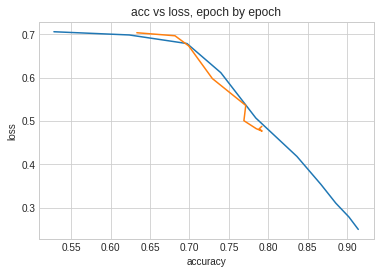

In [7]:
make_plot(histories_per_fold)

In [8]:
from sklearn.model_selection import StratifiedKFold
import numpy


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
histories_per_fold = []
# split training and validation sets
for i, (train, test) in enumerate(kfold.split(X, Y)):
    print("Fold no:{}".format(i))
    X_train = X[train]
    X_test = X[test]
    Y_test = pd.get_dummies(Y[test])
    Y_train = pd.get_dummies(Y[train])
    
    # make the model
    dropout=0.2
    embed_dim = 64
    model = Sequential()
    model.add(Embedding(max_num_words, embed_dim, input_length = X.shape[1]))
    model.add(Dropout(dropout))
    model.add(Reshape((-1, embed_dim, 1)))
    
    model.add(Conv2D(1, kernel_size=(3,1), activation='sigmoid', kernel_regularizer=l1(0.01)))
    model.add(Dropout(dropout))
    model.add(MaxPooling2D(pool_size=(4,1)))

    model.add(Reshape((-1, embed_dim)))
    model.add(Dropout(dropout))

    model.add(LSTM(12, activation='sigmoid'))
    model.add(Dropout(dropout))
    model.add(Dense(2, activation='softmax', name='output_softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train, Y_train, epochs=10, batch_size=64, verbose=1, validation_data=(X_test,Y_test))
    histories_per_fold.append(history)

Fold no:0
Train on 2400 samples, validate on 600 samples
Epoch 1/10
2400/2400 [==============================] - 5s 2ms/step - loss: 0.7388 - acc: 0.4854 - val_loss: 0.7086 - val_acc: 0.5000
Epoch 2/10
2400/2400 [==============================] - 2s 797us/step - loss: 0.7109 - acc: 0.4988 - val_loss: 0.7080 - val_acc: 0.5000
Epoch 3/10
2400/2400 [==============================] - 2s 1ms/step - loss: 0.7073 - acc: 0.5088 - val_loss: 0.7065 - val_acc: 0.5000
Epoch 4/10
2400/2400 [==============================] - 3s 1ms/step - loss: 0.7061 - acc: 0.5158 - val_loss: 0.7048 - val_acc: 0.5000
Epoch 5/10
2400/2400 [==============================] - 2s 952us/step - loss: 0.7087 - acc: 0.4979 - val_loss: 0.7043 - val_acc: 0.5000
Epoch 6/10
2400/2400 [==============================] - 2s 767us/step - loss: 0.7048 - acc: 0.5037 - val_loss: 0.7025 - val_acc: 0.5000
Epoch 7/10
2400/2400 [==============================] - 2s 750us/step - loss: 0.7029 - acc: 0.5058 - val_loss: 0.7010 - val_acc: 0.50

In this case changing activation function from relu to tanh did not seem to affect very much. But it could
slow down the process.

Using sigmoid on both convolution and lstm seem to stop learning effectively, [this question helped me a bit](https://stackoverflow.com/questions/40761185/what-is-the-intuition-of-using-tanh-in-lstm).

On the other hand, relu sometimes 'dies' and causes problems. leakyrelu or sigmoid helps. But that issue can be 
overcome by changing the optimizer too. This happened to me in the 3rd question of this hw.

Below is lstm with sigmoid, which I now know that does not make sense.

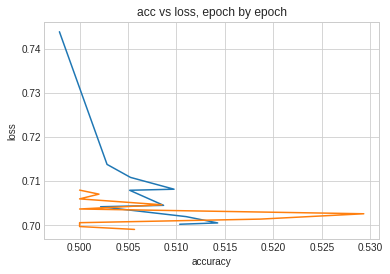

In [9]:
make_plot(histories_per_fold)

In [10]:

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
histories_per_fold = []
# split training and validation sets
for i, (train, test) in enumerate(kfold.split(X, Y)):
    print("Fold no:{}".format(i))
    X_train = X[train]
    X_test = X[test]
    Y_test = pd.get_dummies(Y[test])
    Y_train = pd.get_dummies(Y[train])
    
    # make the model
    dropout=0.2
    embed_dim = 64
    model = Sequential()
    model.add(Embedding(max_num_words, embed_dim, input_length = X.shape[1]))
    model.add(Dropout(dropout))
    model.add(Reshape((-1, embed_dim, 1)))
    
    model.add(Conv2D(1, kernel_size=(3,1), activation='relu', kernel_regularizer=l1(0.01)))
    model.add(Dropout(dropout))
    model.add(MaxPooling2D(pool_size=(4,1)))

    model.add(Reshape((-1, embed_dim)))
    model.add(Dropout(dropout))

    model.add(LSTM(12, activation='tanh'))
    model.add(Dropout(dropout))
    model.add(Dense(2, activation='softmax', name='output_softmax'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train, Y_train, epochs=10, batch_size=64, verbose=1, validation_data=(X_test,Y_test))
    histories_per_fold.append(history)


Fold no:0
Train on 2400 samples, validate on 600 samples
Epoch 1/10
2400/2400 [==============================] - 4s 2ms/step - loss: 0.7056 - acc: 0.5475 - val_loss: 0.6985 - val_acc: 0.6800
Epoch 2/10
2400/2400 [==============================] - 2s 774us/step - loss: 0.6841 - acc: 0.6692 - val_loss: 0.6771 - val_acc: 0.6383
Epoch 3/10
2400/2400 [==============================] - 2s 790us/step - loss: 0.6335 - acc: 0.7225 - val_loss: 0.6215 - val_acc: 0.7467
Epoch 4/10
2400/2400 [==============================] - 2s 830us/step - loss: 0.5559 - acc: 0.7671 - val_loss: 0.5605 - val_acc: 0.7850
Epoch 5/10
2400/2400 [==============================] - 2s 834us/step - loss: 0.5027 - acc: 0.7850 - val_loss: 0.5245 - val_acc: 0.7483
Epoch 6/10
2400/2400 [==============================] - 2s 833us/step - loss: 0.4340 - acc: 0.8242 - val_loss: 0.4813 - val_acc: 0.7900
Epoch 7/10
2400/2400 [==============================] - 2s 905us/step - loss: 0.3955 - acc: 0.8479 - val_loss: 0.4658 - val_acc: 

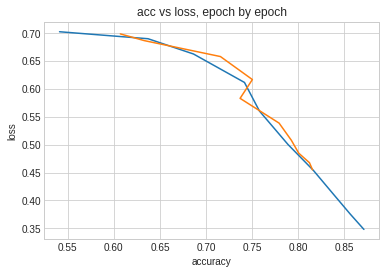

In [11]:
make_plot(histories_per_fold)

rmsprob did not do make a lot of difference compred to adam. they bot performed much better than sgd but that was to be expected. [Keras has small explanations and recommendations on optimizers](https://keras.io/optimizers/)